In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 인물사진

In [2]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

In [3]:
import os
img_path = '/content/drive/MyDrive/Colab Notebooks/Aiffel/Exploration/Exploration8/aiffel human_segmentation/ryu.jpg'
img_orig = cv2.imread(img_path)
print(img_orig.shape)

(464, 500, 3)


In [4]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [5]:
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = '/content/drive/MyDrive/Colab Notebooks/Aiffel/Exploration/Exploration8/aiffel human_segmentation'
tf.io.gfile.makedirs(model_dir)

print('temp directory:', model_dir)
download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
  urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                             download_path)
  
MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /content/drive/MyDrive/Colab Notebooks/Aiffel/Exploration/Exploration8/aiffel human_segmentation
model loaded successfully!


In [6]:
img_resized, seg_map = MODEL.run(img_orig)
print(img_orig.shape, img_resized.shape, seg_map.max())

(464, 500, 3) (476, 513, 3) 15


In [7]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

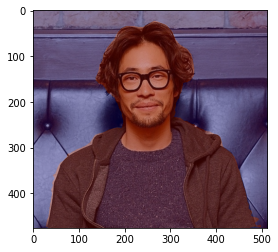

In [8]:
img_show = img_resized.copy()
seg_map = np.where(seg_map==15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

In [9]:
# ## 실험

# img_show = img_resized.copy()
# seg_map = np.where(seg_map==15, 15, 0) # 예측 중 사람만 추출
# img_mask = seg_map * (255/seg_map.max()) # 255 normalization
# img_mask = img_mask.astype(np.uint8)
# color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
# img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0) ### 여기 숫자 조정해보기

# plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
# plt.show()

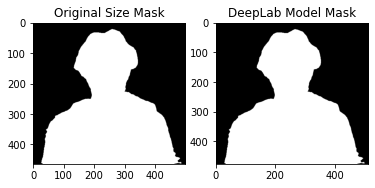

In [10]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY) ## 경계가 blur됨. 128을 기준으로 이하는 0, 이상은 255

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

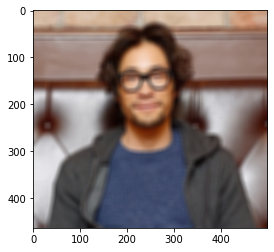

In [11]:
img_orig_blur = cv2.blur(img_orig, (13,13)) # (13,13)은 blurring kernel size를 뜻함. 높아지면 blur심해짐
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

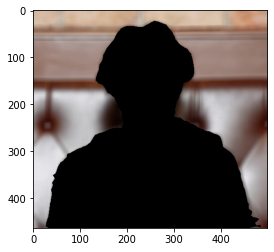

In [12]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

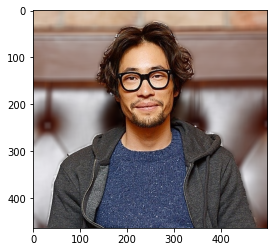

In [13]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 문제점 파악

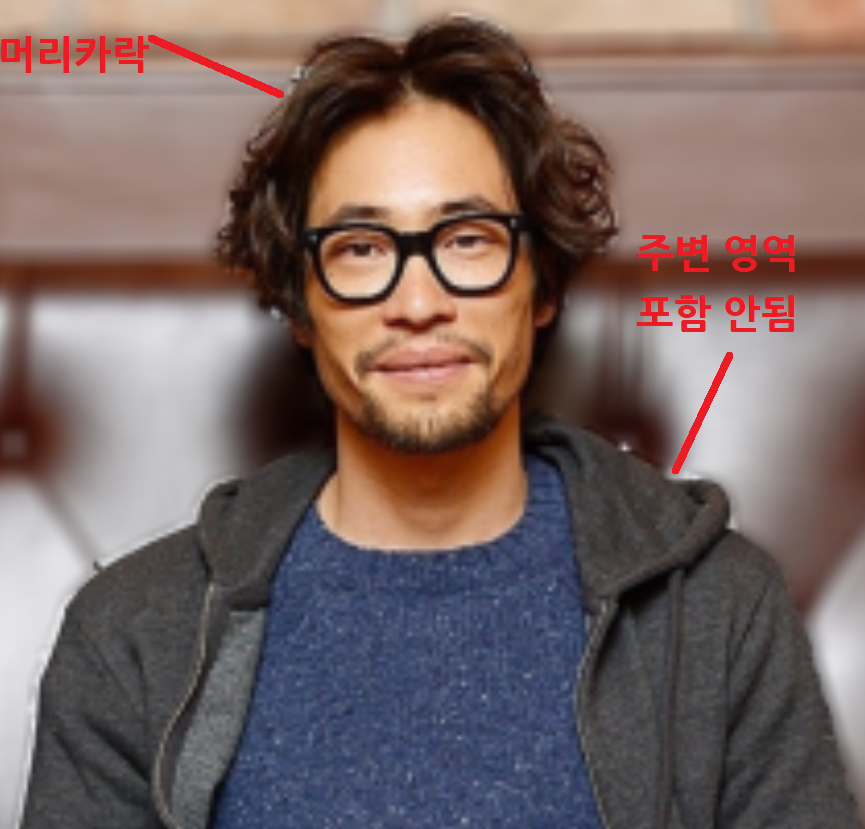

문제점1. 머리카락 주변은 blur 처리가 되지 않은 것을 발견할 수 있습니다.  
문제점2. 인물 주위가 전체적으로 뿌옇거나 일부 영역이 blur처리 돼있지 않습니다.

-----------------

## 해결방법

해당 이미지를 작업할 때 DeepLabModel을 통해 인식한 사람의 영역을 떼어낸 뒤 기존의 이미지에 검은색 mask를 입혔습니다.  
이렇게 하나의 레이어에 픽셀을 덮어 씌우는 방식을 적용하기 때문에 위와 같은 현상이 나타난다고 생각합니다.  
제가 생각한 해결 방식은 두가지입니다.  
  
1. 원본 이미지를 추출하기 전에 밝은 부분을 더욱 밝게, 어두운 부분을 더욱 어둡게 만들어 보다 정밀하게 이미지를 추출하는 것입니다.  
2. 목표로 하는 물체를 약간 포함하도록 마스크를 추출하고, bitwise 연산을 하는 것이 아니라 기존의 이미지 위에 올리는 것입니다. 즉, 레이어를 2개로 만드는 것입니다. 이렇게 되면 약간 더 자연스럽게 blur 처리가 되지 않을까 생각합니다.

# 고양이사진

In [14]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

In [15]:
import os
img_path = '/content/drive/MyDrive/Colab Notebooks/Aiffel/Exploration/Exploration8/aiffel human_segmentation/cat2.webp'
img_orig = cv2.imread(img_path)
print(img_orig.shape)

(640, 960, 3)


In [16]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [17]:
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = '/content/drive/MyDrive/Colab Notebooks/Aiffel/Exploration/Exploration8/aiffel human_segmentation'
tf.io.gfile.makedirs(model_dir)

print('temp directory:', model_dir)
download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
  urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                             download_path)
  
MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /content/drive/MyDrive/Colab Notebooks/Aiffel/Exploration/Exploration8/aiffel human_segmentation
model loaded successfully!


In [18]:
img_resized, seg_map = MODEL.run(img_orig)
print(img_orig.shape, img_resized.shape, seg_map.max())

(640, 960, 3) (342, 513, 3) 11


In [19]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

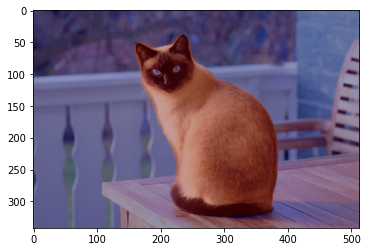

In [20]:
img_show = img_resized.copy()
seg_map = np.where(seg_map==8, 8, 0) # 예측 중 고양이만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

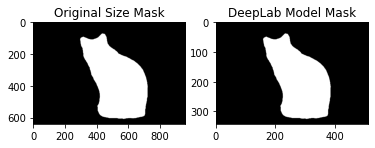

In [21]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY) ## 경계가 blur됨. 128을 기준으로 이하는 0, 이상은 255

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

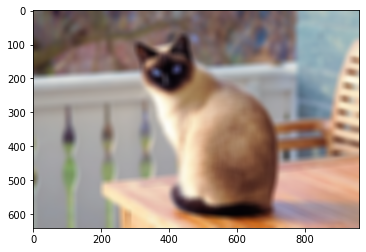

In [22]:
img_orig_blur = cv2.blur(img_orig, (20,20)) # (13,13)은 blurring kernel size를 뜻함. 높아지면 blur심해짐
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

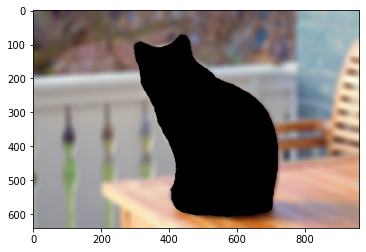

In [23]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

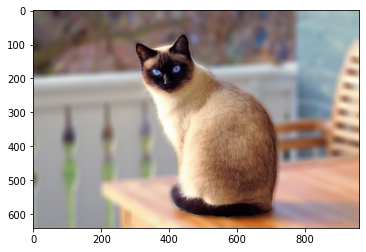

In [24]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

크로마키

In [25]:
#배경
back_path = '/content/drive/MyDrive/Colab Notebooks/Aiffel/Exploration/Exploration8/aiffel human_segmentation/background.jpg'
back_orig = cv2.imread(back_path, cv2.COLOR_BGR2RGB)
back_orig = cv2.cvtColor(back_orig, cv2.COLOR_BGR2RGB)
print(back_orig.shape)

(1280, 960, 3)


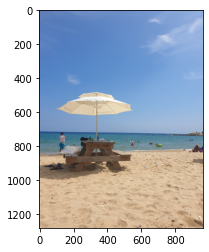

In [26]:
plt.imshow(back_orig)

In [27]:
back_resized, back_map = MODEL.run(img_orig)
print(back_orig.shape, back_resized.shape, back_map.max())

(1280, 960, 3) (342, 513, 3) 11


In [28]:
#고양이
import os
img_path = '/content/drive/MyDrive/Colab Notebooks/Aiffel/Exploration/Exploration8/aiffel human_segmentation/cat2.webp'
img_orig = cv2.imread(img_path)
print(img_orig.shape)

(640, 960, 3)


In [29]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [30]:
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = '/content/drive/MyDrive/Colab Notebooks/Aiffel/Exploration/Exploration8/aiffel human_segmentation'
tf.io.gfile.makedirs(model_dir)

print('temp directory:', model_dir)
download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
  urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                             download_path)
  
MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /content/drive/MyDrive/Colab Notebooks/Aiffel/Exploration/Exploration8/aiffel human_segmentation
model loaded successfully!


In [31]:
img_resized, seg_map = MODEL.run(img_orig)
print(img_orig.shape, img_resized.shape, seg_map.max())

(640, 960, 3) (342, 513, 3) 11


In [32]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

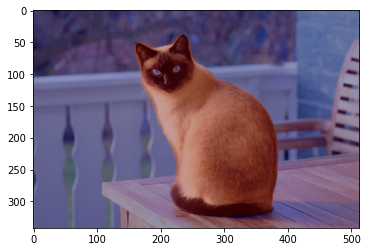

In [33]:
img_show = img_resized.copy()
seg_map = np.where(seg_map==8, 8, 0) # 예측 중 고영이만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

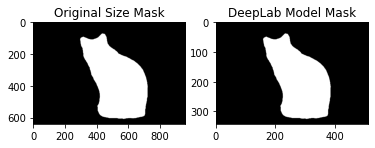

In [34]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY) ## 경계가 blur됨. 128을 기준으로 이하는 0, 이상은 255

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

In [35]:
## int변환
back_orig = back_orig.astype(np.uint8)
img_bg_mask = img_bg_mask.astype(np.uint8)

In [36]:
back_orig.shape

(1280, 960, 3)

In [37]:
# 리사이즈
back_resize = cv2.resize(back_orig, img_bg_mask.shape[:2][::-1], interpolation=cv2.INTER_AREA)
back_resize = cv2.cvtColor(back_resize, cv2.COLOR_BGR2RGB)
back_resize.shape

(640, 960, 3)

In [38]:
img_orig.shape[:2][::-1]

(960, 640)

In [39]:
img_bg_mask.shape

(640, 960, 3)

(<matplotlib.image.AxesImage at 0x7f5ab41ee810>, (640, 960, 3))

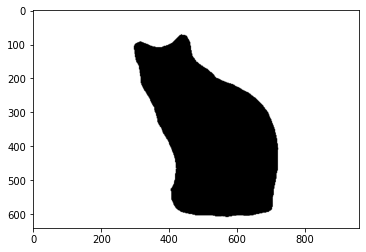

In [40]:
img_bg_mask = cv2.cvtColor(img_bg_mask, cv2.COLOR_BGR2RGB)
plt.imshow(img_bg_mask), img_bg_mask.shape

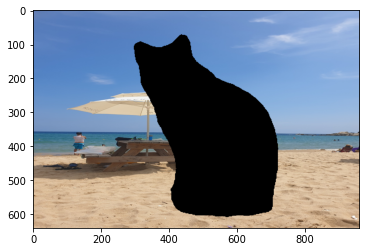

In [41]:
img_bg_mask = cv2.bitwise_not(img_mask_color)
# 컬러 rgb로 변환
img_bg_mask = cv2.cvtColor(img_bg_mask, cv2.COLOR_BGR2RGB)
#
img_bg_blur = cv2.bitwise_and(back_resize, img_bg_mask)

plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

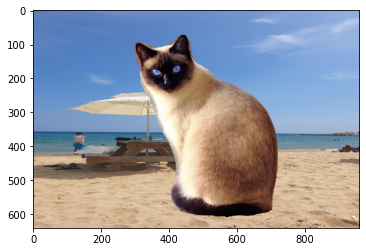

In [42]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()